In [201]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_selected(df, columns, start, end):
    plot_data(df.loc[start:end, columns])

def data_path(symbol, root="/home"):
    return os.path.join(root,"andre","trading-bot-workshop",
                        "ml_trade","ML4T_2018Spring","data",
                        "{}.csv".format(str(symbol)))
def allocate_funds(allocs, df):
    return allocs * df

def normalize_df(df):
    normalized_data = df/df.iloc[0,:]
    return normalized_data

def get_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    """
    if 'SPY' not in symbols:
        symbols.insert(0,'SPY')
    """
        
    for stock in symbols:
        df_temp = pd.read_csv(data_path(stock), index_col="Date",
                             parse_dates=True, usecols=['Date','Adj Close'],
                             na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close':stock})
        df = df.join(df_temp)
        if stock =='SPY':
            df = df.dropna(subset=['SPY'])
    return df.dropna()

def compute_daily_returns(df):
    drv = df.copy()
    drv = (drv[1:]/drv[:-1].values) - 1
    drv.iloc[0] = 0
    return drv

def plot_data(df, title="Stock Prices"):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prices")
    plt.show()
    
def plot_returns(df, title="Returns"):
    plt.figure(figsize=(21,7))
    for c in df.columns.values:
        plt.plot(df.index, df[c], lw=3, alpha=0.8, label=c)
        plt.legend(loc='upper right', fontsize=12)
        plt.ylabel('daily returns')

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate)/portfolio_std_dev
    return results, weights_record

def display_simulated_portfolio(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=cov_matrix.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=cov_matrix.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("\n")
    print("Minimum Volatity Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatilty:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("\n")

    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:], results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label="Minimum Volatility")
    plt.title("Simulated Portfolio Optimization Based on Efficient Frontier")
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    return max_sharpe_allocation, min_vol_allocation

def optimize():
    dates = pd.date_range('2008-01-01','2009-01-01')
    
    symbols=['GOOG','AAPL','GLD','XOM']
    sv = 1000000
    
    df = get_data(symbols, dates)
    plot_returns(df.fillna(method="ffill"))
    df_pchange = df.pct_change().dropna()
    
    
    mean_returns = df_pchange.mean()
    cov_matrix = df_pchange.cov()
    num_portfolios = 25000
    risk_free_rate = 0.0041
    
    
    max_SA, min_VA = display_simulated_portfolio(mean_returns, cov_matrix, num_portfolios, risk_free_rate)
    max_SA_weights = max_SA.values/100
    min_VA_weights = min_VA.values/100

    ND = normalize_df(df)
    allocated_max_SA = allocate_funds(max_SA_weights, ND)
    allocated_min_SA = allocate_funds(min_VA_weights, ND)
    
    max_SA_portfolio_vals = allocated_max_SA.sum(axis=1)
    max_SA = max_SA_portfolio_vals.iloc[:].rename("max SA")
    max_SA = pd.DataFrame(max_SA)
    
    
    min_VA_portfolio_vals = allocated_min_SA.sum(axis=1)
    min_VA = min_VA_portfolio_vals.iloc[:].rename("min VA")
    min_VA = pd.DataFrame(min_VA)
    
    spy = get_data(['SPY'],dates)
    norm_SPY = normalize_df(spy)
    norm_SPY = norm_SPY.join(max_SA)
    norm_SPY = norm_SPY.join(min_VA)
    
    plot_selected(norm_SPY, ['SPY', 'max SA', 'min VA'], start='2008-01-01', end='2009-01-01')

Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.04
Annualised Volatility: 0.3


            GOOG  AAPL    GLD   XOM
allocation  0.83  0.14  63.73  35.3


Minimum Volatity Portfolio Allocation

Annualised Return: -0.16
Annualised Volatilty: 0.26


             GOOG   AAPL    GLD   XOM
allocation  15.68  15.86  67.49  0.97




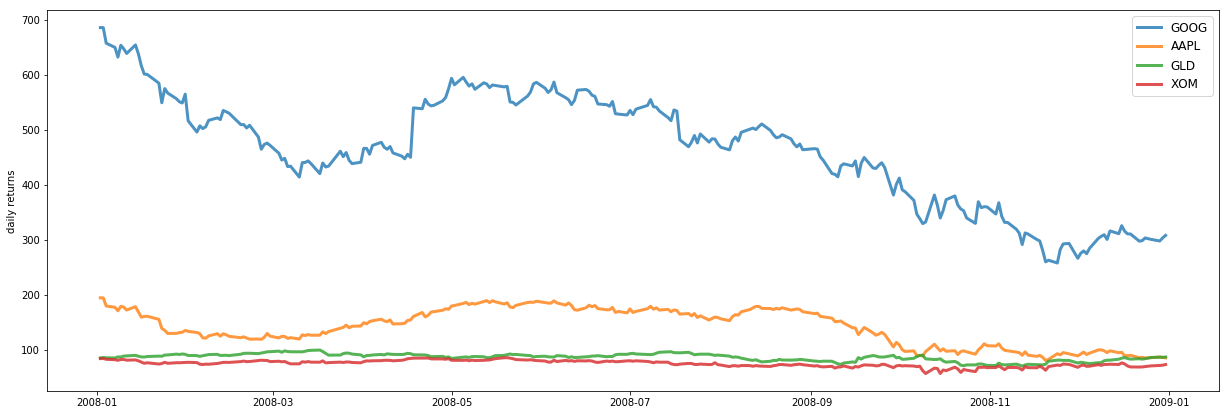

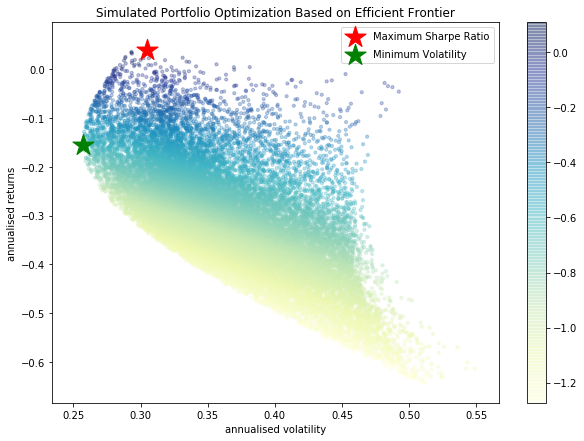

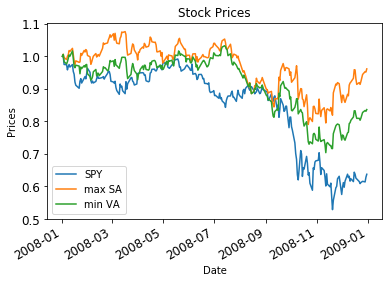

In [202]:
if __name__ == "__main__":
    optimize()